In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
!pip install -q pytorch_metric_learning
clear_output()

Two types of task are available:

a) Identify wether two images belong to the same person or not

b) Recognize a person, using the set of known people

Here the model trained to extract features from two inputs (images of persons) with respect to the loss function, that measures the abiblity of model to generate different features for different people and similar (small euclidian distance) features for the same person

In [ ]:

# same dataset, but structured
from sklearn.datasets import fetch_lfw_people, fetch_lfw_pairs
# Usage
data_train = fetch_lfw_pairs(subset='train', color=True)
data_test = fetch_lfw_pairs(subset='test', color=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torchvision import transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from glob import glob
from tqdm.notebook import trange, tqdm

from pytorch_metric_learning import losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report, auc

In [3]:
torch.random.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)

IMAGE_SIZE = int(input('Set image size: '))  # 100 - Scratch, 224 for FaceModel and FaceRecognizer
BATCH_SIZE = 64
epochs = 200
PATH = r'/content/drive/My Drive/data/face_model_checkpoint.pth'
PATH_DAG = r'/content/drive/My Drive/data/dag_model_checkpoint.pth'
PATH_EXP = r'/content/drive/My Drive/data/exp_model_checkpoint.pth'
model_path = r'/content/drive/My Drive/data/entire_model.pth'

weights_path = r'/content/drive/My Drive/data/vgg_face_dag.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Set image size: 100


'cuda'

In [4]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]
df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]
df.sample(5)

,Image_dir,Name
4430,lfw_funneled/Juan_Carlos_Ferrero/Juan_Carlos_F...,Juan_Carlos_Ferrero
12342,lfw_funneled/Peri_Gilpin/Peri_Gilpin_0001.jpg,Peri_Gilpin
7112,lfw_funneled/George_W_Bush/George_W_Bush_0123.jpg,George_W_Bush
2202,lfw_funneled/Yang_Jianli/Yang_Jianli_0001.jpg,Yang_Jianli
4759,lfw_funneled/Colin_Powell/Colin_Powell_0199.jpg,Colin_Powell


In [5]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=123)
train, valid = train_test_split(train, test_size=0.05, shuffle=True, random_state=123)  # init random_state=123
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape, valid.shape, test.shape

((11313, 2), (596, 2), (1324, 2))

In [6]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.RandomHorizontalFlip(),
                              T.RandomAffine(5, (0.01, 0.2), scale=(0.95, 1.05)),

                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.95, 1.05),
                                            hue=0.05),
                              T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                              T.RandomRotation(degrees=(-10, 10)),

                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize((0.5), (0.5))  # from scratch
                              # for pretrained: FaceModel or FaceRecognizer
                              #T.Normalize(mean=(129.186279296875, 104.76238250732422, 93.59396362304688),
                              #            std=(1., 1., 1.))
])
valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize((0.5), (0.5))
                              #T.Normalize(mean=(129.186279296875, 104.76238250732422, 93.59396362304688),
                              #            std=(1., 1., 1.))
])

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    return image, 0

In [24]:
# custom dataset
class FaceDataset(torch.utils.data.Dataset):
      def __init__(self, df, transforms=None, is_cosine=0):
          self.df = df
          self.transforms = transforms
          self.is_cosine = is_cosine

      def __len__(self):
          return len(self.df)

      def __getitem__(self, ix):
          itemA = self.df.loc[ix, 'Image_dir']
          itemA_name = self.df.loc[ix, 'Name']
          same_person = np.random.randint(2)
          if same_person:
              itemB_ser = self.df.loc[self.df.Name == itemA_name, 'Image_dir']
              itemB_idx = itemB_ser.index
              if len(itemB_idx) > 1:
                  itemB = itemB_ser[np.random.choice(itemB_idx)]
                  itemB_name = self.df.loc[self.df['Image_dir'] == itemB, 'Name'].values[0]
              else:
                  same_person = 0
          if not same_person:
              other_persons_idx = self.df.loc[~(self.df.Name == itemA_name), :].index
              itemB_row = self.df.loc[np.random.choice(other_persons_idx)]
              itemB = itemB_row['Image_dir']
              itemB_name = itemB_row['Name']
          imageA = cv2.imread(itemA)
          imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
          imageB = cv2.imread(itemB)
          imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)

          imageA, _ = crop_face(imageA)
          imageB, _ = crop_face(imageB)

          if self.transforms is not None:
              imageA = self.transforms(imageA)
              imageB = self.transforms(imageB)

          label = np.array([1 - (same_person - self.is_cosine)])  # 0 if same, 1 if different when is_cosine=0 - basic
          label[label == 2] = -1
                    
          return imageA, imageB, label

      def collate_fn(self, batch):
          imgsA, imgsB, labels = list(zip(*batch))
          imgsA = [img[None] for img in imgsA]
          imgsB = [img[None] for img in imgsB]
          labels = [torch.tensor([label]) for label in labels]
          imgsA, imgsB, labels = [torch.cat(i).to(device) for i in [imgsA, imgsB, labels]]
          return imgsA, imgsB, labels

In [ ]:
# sklearn Dataset

class SklearnDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset['target'])

    def __getitem__(self, ix):
        pair = self.dataset['pairs'][ix]
        target = self.dataset['target'][ix]
        imageA = pair[0].astype(np.uint8)
        imageB = pair[1].astype(np.uint8)
        if self.transforms is not None:
            imageA = self.transforms(imageA)
            imageB = self.transforms(imageB)
        return imageA, imageB, target

    def collate_fn(self, batch):
        imgsA, imgsB, labels = list(zip(*batch))
        imgsA = [img[None] for img in imgsA]
        imgsB = [img[None] for img in imgsB]
        labels = [torch.tensor([label]) for label in labels]
        imgsA, imgsB, labels = [torch.cat(i).to(device) for i in [imgsA, imgsB, labels]]
        return imgsA, imgsB, labels

In [ ]:
# sklearn datasets
sk_train_ds = SklearnDataset(data_train, train_transforms)
sk_valid_ds = SklearnDataset(data_test, valid_transforms)

In [25]:
# custom datasets
train_ds = FaceDataset(train, train_transforms, is_cosine=1)
valid_ds = FaceDataset(valid, train_transforms, is_cosine=1)

what_dataset = input('Wich dataset to use: ') # custom
train_ds = train_ds if what_dataset == 'custom' else sk_train_ds
valid_ds = valid_ds if what_dataset == 'custom' else sk_valid_ds

# add num_workers=8
train_dataloader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, collate_fn=train_ds.collate_fn, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, shuffle=False, batch_size=BATCH_SIZE, collate_fn=valid_ds.collate_fn, drop_last=True)

Wich dataset to use: custom


In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, epoch=None, model=None, optimizer=None, scheduler=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = { 
                          'epoch': epoch,
                          'model': model,
                          'optimizer': optimizer,
                          'scheduler': scheduler,
                          'early': self,
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [11]:
class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face_dag(weights_path=None, **kwargs):
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [12]:
def get_model_pretrained():
    model = vgg_face_dag(weights_path=weights_path)

    for param in model.parameters():
        param.requires_grad = False

    # model.fc8 = nn.Linear(4096, 50)

    return model

# experimental model
class FaceRecognizer(nn.Module):
    """
    model that extracts features by face_model
    takes the difference between outputs
    and inputs it in dense network to perform binary classification
    of wether it is the same person or not
    take input1, input2 and labels from dataloader
    """
    def __init__(self):
        super(FaceRecognizer, self).__init__()
        self.face_model = get_model_pretrained()
        self.fc = nn.Sequential(
            nn.Linear(2622, 1300),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1300, 650),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(650, 325),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(325, 150),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(150, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )

    def forward(self, input1, input2):
        face_out1 = self.face_model(input1)
        face_out2 = self.face_model(input2)
        face_distance = face_out1 - face_out2
        x = self.fc(face_distance)        
        return x

def convBlock(ni, no):
    return torch.nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, stride=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

class ScratchModel(nn.Module):
    def __init__(self):
        super(ScratchModel, self).__init__()
        self.features = nn.Sequential(
            convBlock(3, 8),
            convBlock(8, 16),
            # maybe MaxPool2d layer here 16*50*50
            convBlock(16, 32),
            convBlock(32, 32),
            nn.AdaptiveAvgPool2d((7)),  # 32*7*7
            nn.Flatten(),
            nn.Linear(32*7*7, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )
    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

class FaceModel(nn.Module):
    def __init__(self, model):
        super(FaceModel, self).__init__()
        self.model = model

    def forward(self, input1, input2):
        output1 = self.model(input1)
        output2 = self.model(input2)
        return output1, output2

In [36]:
model = ScratchModel().to(device)
# model = FaceModel(get_model_pretrained()).to(device)
# model = FaceRecognizer().to(device)

from torchsummary import summary
summary(model, [(3,IMAGE_SIZE,IMAGE_SIZE), (3,IMAGE_SIZE,IMAGE_SIZE)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1          [-1, 3, 100, 100]               0
            Conv2d-2          [-1, 8, 100, 100]             224
              ReLU-3          [-1, 8, 100, 100]               0
       BatchNorm2d-4          [-1, 8, 100, 100]              16
           Dropout-5          [-1, 8, 100, 100]               0
            Conv2d-6         [-1, 16, 100, 100]           1,168
              ReLU-7         [-1, 16, 100, 100]               0
       BatchNorm2d-8         [-1, 16, 100, 100]              32
           Dropout-9         [-1, 16, 100, 100]               0
           Conv2d-10         [-1, 32, 100, 100]           4,640
             ReLU-11         [-1, 32, 100, 100]               0
      BatchNorm2d-12         [-1, 32, 100, 100]              64
          Dropout-13         [-1, 32, 100, 100]               0
           Conv2d-14         [-1, 32, 1

In [26]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidian_distance = nn.functional.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidian_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidian_distance, min=0.0), 2))
        accuracy = ((euclidian_distance>0.6) == label).float().mean()
        return loss_contrastive, accuracy

loss_fn = nn.CosineEmbeddingLoss()

def similarity(output1, output2, threshold=0.6, display=False):
    euclidian_distance = nn.functional.pairwise_distance(output1, output2)
    if display:
        print('Distance:', euclidian_distance.item(), 'threshold:', threshold)
    return 1 if euclidian_distance.item() < threshold else 0

def preprocess_input(path):
    input = cv2.imread(path)
    input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
    input, _ = crop_face(input)
    input = valid_transforms(input)[None].to(device)
    return input

In [39]:
def train_one_batch(model, data, optimizer, criterion):
    model.train()
    imgsA, imgsB, labels = data
    optimizer.zero_grad()
    featsA, featsB = model(imgsA, imgsB)
    loss, accuracy = criterion(featsA, featsB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), accuracy.item()

@torch.no_grad()
def validate(model, data, criterion):
    model.eval()
    imgsA, imgsB, labels = data
    featsA, featsB = model(imgsA, imgsB)
    loss, accuracy = criterion(featsA, featsB, labels)
    return loss.item(), accuracy.item()

def load_model(path):
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    scheduler = checkpoint['scheduler']
    early = checkpoint['early']
    return model, optimizer, epoch, scheduler, early 

In [40]:
# cosine similarity

def train_one_batch(model, data, optimizer, criterion=loss_fn):
    model.train()
    imgsA, imgsB, labels = data
    labels.squeeze_()
    optimizer.zero_grad()
    featsA, featsB = model(imgsA, imgsB)
    loss = criterion(featsA, featsB, labels)
    loss.backward()
    optimizer.step()

    labels.clamp_(min=0, max=1)
    cosine_sim = F.cosine_similarity(featsA, featsB)  # calculates similarity in range [0,1]. Not distance
    accuracy = ((cosine_sim>0.5) == labels).float().mean()

    return loss.item(), accuracy.item()

@torch.no_grad()
def validate(model, data, criterion=loss_fn):
    model.eval()
    imgsA, imgsB, labels = data
    labels.squeeze_()
    featsA, featsB = model(imgsA, imgsB)
    loss = criterion(featsA, featsB, labels)

    labels.clamp_(min=0, max=1)
    cosine_sim = F.cosine_similarity(featsA, featsB)
    accuracy = ((cosine_sim>0.5) == labels).float().mean()

    return loss.item(), accuracy.item()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-6, factor=0.1)
early_stop = EarlyStopping(path=PATH)

In [ ]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    epoch_train_acc, epoch_valid_acc = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, accuracy = train_one_batch(model, batch, optimizer)
        epoch_train_losses.append(batch_train_loss)
        epoch_train_acc.append(accuracy)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    epoch_train_accuracy = np.array(epoch_train_acc).mean()
    train_losses.append(epoch_train_loss)

    print(f'Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_accuracy:.4f}')

    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, accuracy = validate(model, batch)
        epoch_valid_losses.append(batch_valid_loss)
        epoch_valid_acc.append(accuracy)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    epoch_valid_accuracy = np.array(epoch_valid_acc).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}, Valid accuracy: {epoch_valid_accuracy:.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early_stop(epoch_valid_loss, epoch=epoch, model=model, optimizer=optimizer, scheduler=scheduler)
    if early_stop.early_stop:
        print(f'Validation loss did not improve for {early_stop.patience} epochs. Training stopped.')
        # model.load_state_dict(torch.load(PATH))
        model, optimizer, epoch, scheduler, early = load_model(PATH)
        break

In [41]:
model, optimizer, epoch, scheduler, early = load_model(PATH)

In [46]:
test[test.Name == 'Angelina_Jolie']['Image_dir'].index

Int64Index([19, 54, 61, 796, 989, 1258], dtype='int64')

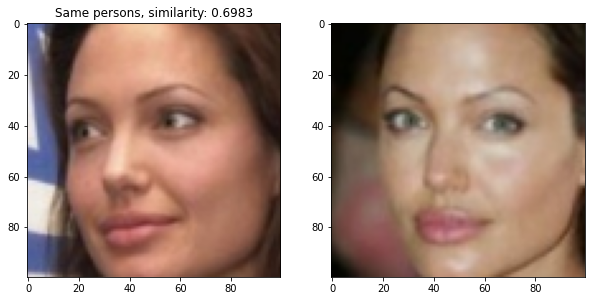

In [55]:
train_im_path = train[train.Name == 'Angelina_Jolie']['Image_dir'].loc[6694]
test_im_path = test[test.Name == 'Angelina_Jolie']['Image_dir'].loc[61]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
with torch.no_grad():
    out1, out2 = model(input1, input2)
similarity = F.cosine_similarity(out1, out2)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.title(f'{"Same" if similarity.item() > 0.5 else "different"} persons, similarity: {similarity.item():.4f}')
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()

tensor([0.5997], device='cuda:0')

In [ ]:
# experimental train and validate ## DO NOT START CELL IF TRAINING SCRATCH_MODEL ##
def train_one_batch(model, data, optimizer, criterion):
    model.train()
    imgsA, imgsB, labels = data
    preds = model(imgsA, imgsB)
    labels = labels.squeeze()

    optimizer.zero_grad()
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    predicted_labels = torch.max(preds, 1)[1].cpu().numpy()
    true_labels = labels.cpu().numpy()
    probabilities = nn.Softmax(dim=1)(preds)[:, 1].cpu().detach().numpy()

    return loss.item(), predicted_labels, true_labels, probabilities

@torch.no_grad()
def validate(model, data, criterion):
    model.eval()
    imgsA, imgsB, labels = data
    preds = model(imgsA, imgsB)
    labels = labels.squeeze()
    loss = criterion(preds, labels)

    predicted_labels = torch.max(preds, 1)[1].cpu().numpy()
    true_labels = labels.cpu().numpy()
    probabilities = nn.Softmax(dim=1)(preds)[:, 1].cpu().numpy()

    return loss.item(), predicted_labels, true_labels, probabilities

In [ ]:
# experimental loss, optimizer, scheduler, early (PATH_EXP) ## DO NOT START CELL IF TRAINING SCRATCH_MODEL ##
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early_stop = EarlyStopping(path=PATH_EXP)

In [ ]:
# experimental
model, optimizer, _, scheduler, early_stop = load_model(PATH_EXP)

In [ ]:
# experimental train loop ## DO NOT START CELL IF TRAINING SCRATCH_MODEL ##
train_losses, valid_losses = [], []
for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    predicted_epoch_labels, true_epoch_labels, predicted_epoch_probas = np.array([]), np.array([]), np.array([])

    for i, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, predicted_labels, true_labels, probs = train_one_batch(model, batch, optimizer, criterion)
        epoch_train_losses.append(batch_train_loss)
        predicted_epoch_labels = np.append(predicted_epoch_labels, predicted_labels)
        predicted_epoch_probas = np.append(predicted_epoch_probas, probs)
        true_epoch_labels = np.append(true_epoch_labels, true_labels)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    f1_train_epoch = f1_score(true_epoch_labels, predicted_epoch_labels, average='weighted')
    accuracy_train_epoch = (true_epoch_labels == predicted_epoch_labels).mean()
    roc_auc_train_epoch = roc_auc_score(true_epoch_labels, predicted_epoch_probas, average='weighted')
    print(f'Train loss: {epoch_train_loss:.4f}, train F-score: {f1_train_epoch:.4f}, train roc_auc: {roc_auc_train_epoch:.4f}')
    print(f'Train accuracy: {accuracy_train_epoch:.4f}')

    predicted_epoch_labels, true_epoch_labels, predicted_epoch_probas = np.array([]), np.array([]), np.array([])
    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, predicted_labels, true_labels, probs = validate(model, batch, criterion)
        epoch_valid_losses.append(batch_valid_loss)
        predicted_epoch_labels = np.append(predicted_epoch_labels, predicted_labels)
        predicted_epoch_probas = np.append(predicted_epoch_probas, probs)
        true_epoch_labels = np.append(true_epoch_labels, true_labels)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    f1_valid_epoch = f1_score(true_epoch_labels, predicted_epoch_labels)
    roc_auc_valid_epoch = roc_auc_score(true_epoch_labels, predicted_epoch_probas)
    accuracy_valid_epoch = (true_epoch_labels == predicted_epoch_labels).mean()
    print(f'Valid loss: {epoch_valid_loss:.4f}, valid F-score: {f1_valid_epoch:.4f}, valid roc_auc: {roc_auc_valid_epoch:.4f}')
    print(f'Valid accuracy: {accuracy_valid_epoch:.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early_stop(epoch_valid_loss, epoch=epoch, model=model, optimizer=optimizer, scheduler=scheduler)  
    if early_stop.early_stop:
        print(f'Validation loss did not improve for {early_stop.patience} epochs. Training stopped.')
        model, optimizer, epoch, scheduler, early = load_model(PATH_EXP)
        break

In [ ]:
# evaluation for experimental model
random_indices = np.random.choice(test.index, size=1)
test_sampled = test.loc[random_indices]
temp_df = pd.DataFrame(data=np.zeros_like(test_sampled.values), columns=['Name_test', 'Name_pred'])

model.eval()
for i in range(len(test_sampled)):
    dict_names = dict()
    input1 = test_sampled.iloc[i, 0]
    input1 = preprocess_input(input1)
    temp_df.iloc[i, 0] = test_sampled.iloc[i, 1]
    for j in trange(len(train), leave=False):
        input2 = train.iloc[j, 0]
        input2 = preprocess_input(input2)
        pred = model(input1, input2)
        pred = torch.max(pred, 1)[1].item()  # possibly calibrate probability of label as distance threshold
        same = np.abs(pred - 1)  # inverse: we got 0 as same, 1 as other; here same = 1, other = 0 for dict_names
        name = train.iloc[j,1]
        if dict_names.get(name) is not None:
            dict_names[name] += same
        else:
            dict_names[name] = same
    unrecognized = max(list(dict_names.values())) < 1
    if unrecognized:
        pred_name = 'Unknown'
    else:
        pred_name = max(dict_names, key=dict_names.get)
    temp_df.iloc[i, 1] = pred_name
temp_df

  0%|          | 0/11313 [00:00<?, ?it/s]

,Name_test,Name_pred
0,Liu_Mingkang,Unknown


In [ ]:
train[train.Name == 'Liu_Mingkang']

,Image_dir,Name
8221,lfw_funneled/Liu_Mingkang/Liu_Mingkang_0001.jpg,Liu_Mingkang


In [ ]:
train_im_path = train[train.Name == 'Angelina_Jolie']['Image_dir'].loc[2020]
test_im_path = test[test.Name == 'Angelina_Jolie']['Image_dir'].loc[1282]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
pred = model(input1, input2)
print(pred)
pred = torch.max(pred, 1)[1].item()
pred  # that's bad

tensor([[-0.1303,  0.1545]], device='cuda:0', grad_fn=<AddmmBackward0>)


1

In [ ]:
train_im_path = train[train.Name == 'Colin_Powell']['Image_dir'].loc[20]
test_im_path = test[test.Name == 'Colin_Powell']['Image_dir'].loc[93]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
pred = model(input1, input2)
print(pred)
pred = torch.max(pred, 1)[1].item()
pred  # that's bad

tensor([[-0.1303,  0.1545]], device='cuda:0', grad_fn=<AddmmBackward0>)


1

In [ ]:
criterion = ContrastiveLoss()
#criterion = losses.CosFaceLoss(num_classes=2, embedding_size=50)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # if underfit: increase lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)

PATH_W = PATH if model.__class__.__name__ == 'ScratchModel' else PATH_DAG
early = EarlyStopping(path=PATH_W)

# continue training (set early = _ attempting to reset val_loss and counter in early instance)
if model.__class__.__name__ == 'ScratchModel':
    if torch.cuda.is_available():
        try: 
            model, optimizer, epoch, scheduler, _ = load_model(PATH_W) # early eliminated due to restart train
            print('Entire model loaded with CUDA')    
        except:
            model.load_state_dict(torch.load(PATH_W))
            print('Model unfitted') 
    else:
        try:
            model, optimizer, epoch, scheduler, early = load_model(PATH_W)
            print('Entire model loaded with CPU')
        except:
            model.load_state_dict(torch.load(PATH_W, map_location=torch.device('cpu')))
elif model.__class__.__name__ == 'FaceModel':
    try:
        model, optimizer, epoch, scheduler, early = load_model(PATH_W) 
    except:
        print('Model unfitted')
print(model.__class__.__name__)

Entire model loaded with CUDA
ScratchModel


In [ ]:
# skip if nit using multiprocessing with num_workers
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
     print('spawn started')
except RuntimeError as exc:
    print(exc)
    pass

context has already been set


In [ ]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    epoch_train_acc, epoch_valid_acc = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, accuracy = train_one_batch(model, batch, optimizer, criterion)
        epoch_train_losses.append(batch_train_loss)
        epoch_train_acc.append(accuracy)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    epoch_train_accuracy = np.array(epoch_train_acc).mean()
    train_losses.append(epoch_train_loss)

    print(f'Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_accuracy:.4f}')

    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, accuracy = validate(model, batch, criterion)
        epoch_valid_losses.append(batch_valid_loss)
        epoch_valid_acc.append(accuracy)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    epoch_valid_accuracy = np.array(epoch_valid_acc).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}, Valid accuracy: {epoch_valid_accuracy:.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, epoch=epoch, model=model, optimizer=optimizer, scheduler=scheduler)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        #model.load_state_dict(torch.load(PATH_W))
        model, optimizer, epoch, scheduler, early = load_model(PATH_W)
        break

Epoch 1/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.6835, Train accuracy: 0.7104


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.4836, Valid accuracy: 0.8594
--------------------------------------------------
Epoch 2/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.6811, Train accuracy: 0.7047


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.4625, Valid accuracy: 0.8785
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 3/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.6618, Train accuracy: 0.7178


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.4929, Valid accuracy: 0.8594
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 4/200


  0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
# load trained instancies
model, optimizer, epoch, scheduler, early = load_model(PATH_W)

In [ ]:
# model = torch.load(model_path) #, map_location=torch.device('cpu')) # for CPU
model.load_state_dict(torch.load(PATH_W, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
random_indices = np.random.choice(test.index, size=1)
test_sampled = test.loc[random_indices]
temp_df = pd.DataFrame(data=np.zeros_like(test_sampled.values), columns=['Name_test', 'Name_pred'])

model.eval()
for i in range(len(test_sampled)):
    dict_names = dict()
    input1 = test_sampled.iloc[i, 0]
    input1 = preprocess_input(input1)
    temp_df.iloc[i, 0] = test_sampled.iloc[i, 1]
    for j in trange(len(train), leave=False):
        input2 = train.iloc[j, 0]
        input2 = preprocess_input(input2)
        output1, output2 = model(input1, input2)
        sim = similarity(output1, output2)
        name = train.iloc[j,1]
        if dict_names.get(name) is not None:
            dict_names[name] += sim
        else:
            dict_names[name] = sim
    unrecognized = max(list(dict_names.values())) < 1
    if unrecognized:
        pred_name = 'Unknown'
    else:
        pred_name = max(dict_names, key=dict_names.get)
    temp_df.iloc[i, 1] = pred_name
temp_df

In [ ]:
# display sorted dictionary with scores
{k: v for k,v in sorted(dict_names.items(), reverse=True, key=lambda x: x[1])}

Distance: 1.0083606243133545 threshold: 0.6


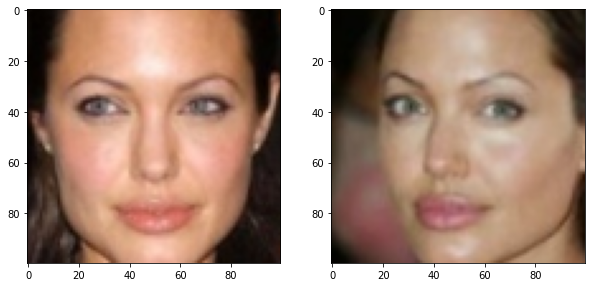

In [ ]:
train_im_path = train[train.Name == 'Angelina_Jolie']['Image_dir'].loc[6755]
test_im_path = test[test.Name == 'Angelina_Jolie']['Image_dir'].loc[1157]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
out1, out2 = model(input1, input2)
similarity(out1, out2, display=True)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()

Distance: 3.1548261642456055 threshold: 0.6


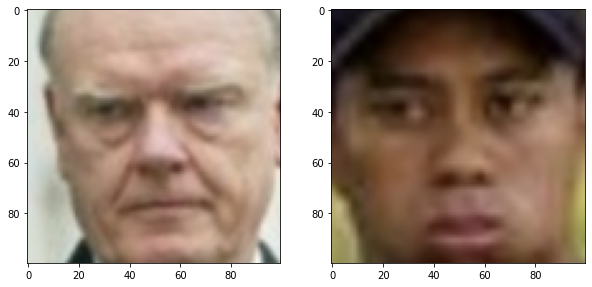

In [ ]:
train_im_path = 'lfw_funneled/John_Snow/John_Snow_0014.jpg'
test_im_path = 'lfw_funneled/Tiger_Woods/Tiger_Woods_0019.jpg'
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
out1, out2 = model(input1, input2)
similarity(out1, out2, display=True)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()

Distance: 3.0389726161956787 threshold: 0.6


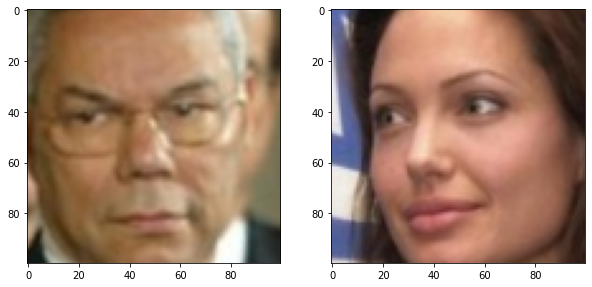

In [ ]:
train_im_path = train[train.Name == 'Colin_Powell']['Image_dir'].loc[11242]
test_im_path = test[test.Name == 'Angelina_Jolie']['Image_dir'].loc[193]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
out1, out2 = model(input1, input2)
similarity(out1, out2, display=True)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()

Distance: 0.3937983214855194 threshold: 0.6


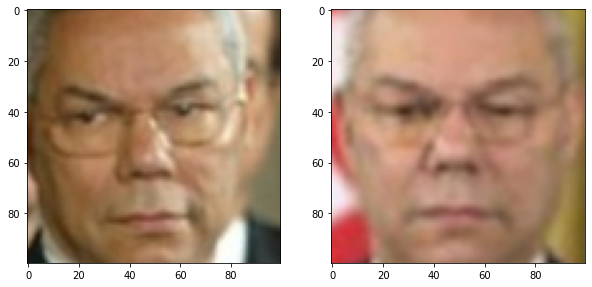

In [ ]:
train_im_path = train[train.Name == 'Colin_Powell']['Image_dir'].loc[11242]
test_im_path = 'lfw_funneled/Colin_Powell/Colin_Powell_0202.jpg'
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
out1, out2 = model(input1, input2)
similarity(out1, out2, display=True)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()